<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2023notebooks/2023_0410fushimi1999_kondo1000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0.1. Colab 実行環境の判定と，それに付随するライブラリの輸入

In [ ]:
%config InlineBackend.figure_format = 'retina'

import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

from IPython import get_ipython
isColab = 'google.colab' in str(get_ipython())

if isColab:

    # termcolor を downgrade しないと colab ではテキストに色がつかない
    !pip install --upgrade termcolor==1.1
    import termcolor

    !pip install jaconv

    # colab 上で MeCab を動作させるために，C コンパイラを起動して，MeCab の構築を行うため時間がかかる。
    !apt install aptitude
    !aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
    !pip install mecab-python3==0.7
    !pip install jaconv
    !pip install japanize_matplotlib

    import MeCab
    mecab_wakati = MeCab.Tagger('-Owakati').parse
    mecab_yomi = MeCab.Tagger('-Oyomi').parse
else:
    from ccap.mecab_settings import yomi as mecab_yomi
    from ccap.mecab_settings import wakati as mecab_wakati

import os
if not os.path.exists('RAM'):
    !git clone https://github.com/ShinAsakawa/RAM.git

from RAM.dataset import *
from RAM import check_vals_performance
from RAM import set_model_from_param_file
from RAM import check_fushimi1999_words

import matplotlib.pyplot as plt
try:
    import japanize_matplotlib
except ImportErrors:
    !pip install japanize_matplotlib
    import japanize_matplotlib

from termcolor import colored

# 1. 訓練済パラメータの読み込み

In [ ]:
%reload_ext autoreload
%autoreload 2

# 直下行では，fname を指定することで，異なる訓練済モデルを読み込むことが可能である。
#fname = 'RAM/2023_0306ram_psylex71_10k_h256_o2p.pt'
#fname = "RAM/2023_0315ram_psylex71_10k_h64_o2p.pt"
#fname = "RAM/2023_0315ram_psylex71_10k_h64_o2p_white_fushimi120.pt"
fname = 'RAM/2023_0313RAM_o2p_psylex71_30k_h256_leda.pt'
_X = torch.load(fname)

# 訓練済ファイルを元に，モデルを復元，パラメータの再設定
encoder, decoder, encoder_optimizer, decoder_optimizer, params, ds = set_model_from_param_file(fname=fname)
fushimi1999_dataset = Fushimi1999_Dataset(source=params['source'], target=params['target'])

check_vals_performance(
    encoder=encoder, decoder=decoder,
    _dataset={'Fushimi1999':fushimi1999_dataset},
    source_vocab=ds.source_list, target_vocab=ds.target_list,
    max_length=ds.maxlen, device=device)

for k, v in sorted(params.items()):
    print(k, colored(v,'blue',attrs=['bold']))

dataset_name psylex71
decoder AttnDecoderRNN(
  (embedding): Embedding(48, 256)
  (attn): Linear(in_features=512, out_features=33, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (gru): GRU(256, 256)
  (out_layer): Linear(in_features=256, out_features=48, bias=True)
)
decoder_optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
dropout_p 0.0
encoder EncoderRNN(
  (embedding): Embedding(2375, 256)
  (gru): GRU(256, 256)
)
encoder_optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
epochs 30
hidden_size 256
loss_func NLLLoss()
losses [1.7812093782818887, 1

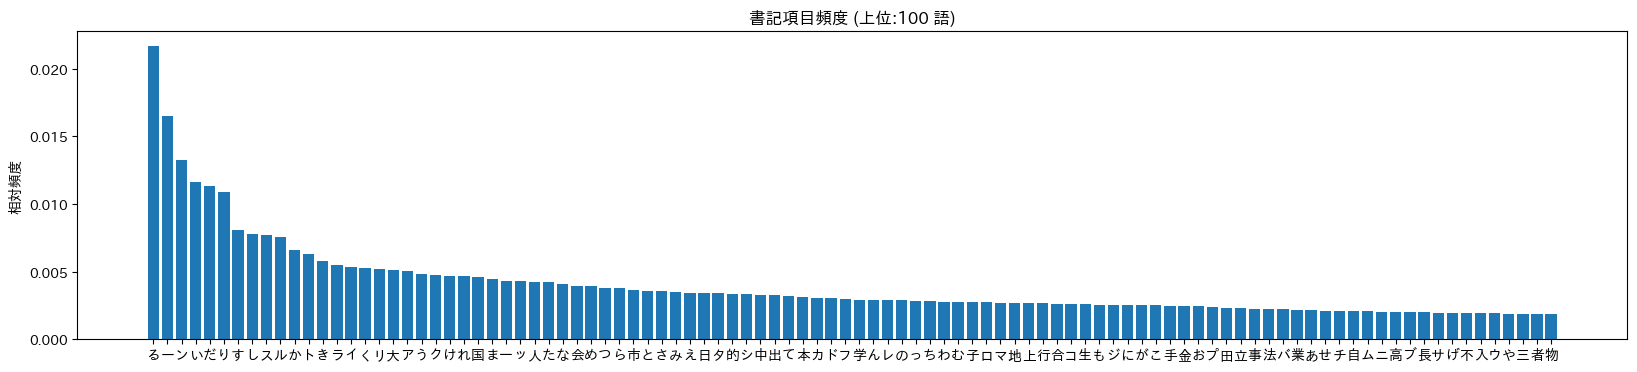

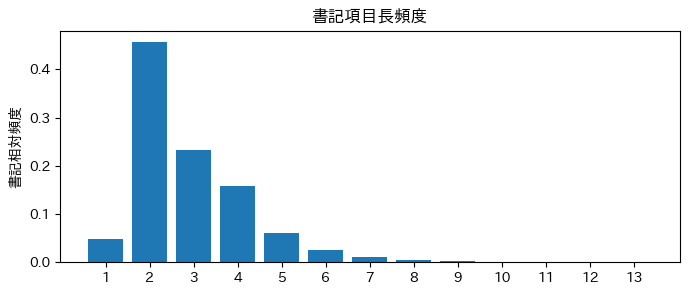

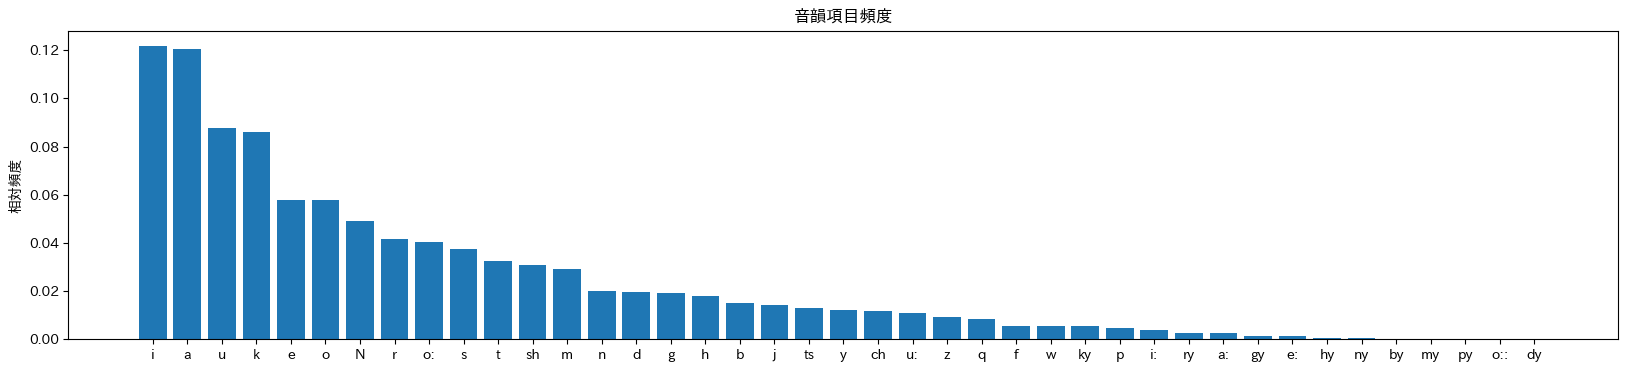

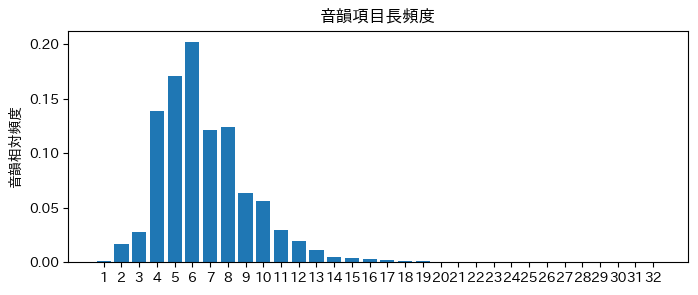

In [ ]:
from RAM import draw_word_char_histgram

is_save_fig = False
draw_word_char_histgram(_dict=ds.data_dict, key='orth', title='書記', figsize2=(8,3))
plt.savefig('2023_0313psylex71_30k_orth_freq.pdf') if is_save_fig else None
draw_word_char_histgram(_dict=ds.data_dict, key='phon', title='音韻', figsize2=(8,3))
plt.savefig('2023_0313psylex71_30k_phon_freq.pdf') if is_save_fig else None


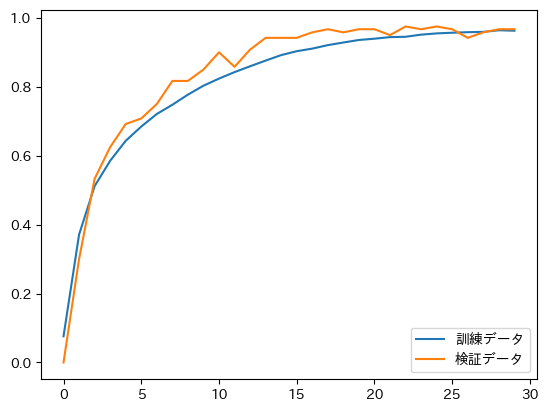

In [ ]:
plt.plot(params['train_accus'], label='訓練データ')
plt.plot([float(v[0].split(':')[-1]) for v in params['val_accus']], label='検証データ')
plt.legend(loc='lower right')

## 1.1 Fushimi1999 の成績

In [ ]:
from RAM import eval_input_seq2seq
import numpy as np

check_fushimi1999_words(encoder=encoder, decoder=decoder, cr_every=4, ds=ds)

cr_every = 4
entropies = []
for i, wrd in enumerate(fushimi1999_list[:]):
#for i, wrd in enumerate(fushimi1999_list[120:]):
    #print(i+121, wrd)
    dec_wrd, topvs = eval_input_seq2seq(encoder=encoder, decoder=decoder, ds=ds, inp_wrd=wrd, isPrint=False)
    dec_wrd = "".join(p for p in dec_wrd[:-1])
    p = np.exp(np.array(topvs)).mean()
    ent = - p * np.log(p)

    #ent = np.array(topvs).mean()
    entropies.append(ent)
    _end = '\n' if ((i+1) % cr_every) == 0 else ", "
    print(f'{i+1:3d} {wrd}->/{dec_wrd}/ {ent:.4f}', end=_end)

001 戦争 :/seNso:/(seNso:) True, 002 倉庫 :/so:ko/(so:ko) True, 003 医学 :/igaku/(igaku) True, 004 注意 :/chu:i/(chu:i) True
005 記念 :/kineN/(kineN) True, 006 番号 :/baNgo:/(baNgo:) True, 007 料理 :/ryo:ri/(ryo:ri) True, 008 完全 :/kaNzeN/(kaNzeN) True
009 開始 :/kaishi/(kaishi) True, 010 印刷 :/iNsatsu/(iNsatsu) True, 011 連続 :/reNzoku/(reNzoku) True, 012 予約 :/yoyaku/(yoyaku) True
013 多少 :/tasho:/(tasho:) True, 014 教員 :/kyo:iN/(kyo:iN) True, 015 当局 :/to:kyoku/(to:kyoku) True, 016 材料 :/zairyo:/(zairyo:) True
017 夕刊 :/yu:kaN/(yu:kaN) True, 018 労働 :/ro:do:/(ro:do:) True, 019 運送 :/uNso:/(uNso:) True, 020 電池 :/deNchi/(deNchi) True
021 反対 :/haNtai/(haNtai) True, 022 失敗 :/shiqpai/(shiqpai) True, 023 作品 :/sakuhiN/(sakuhiN) True, 024 指定 :/shitei/(shitei) True
025 実験 :/jiqkeN/(jiqkeN) True, 026 決定 :/keqtei/(keqtei) True, 027 独占 :/hitoriuranai/(hitoriuranai) True, 028 独身 :/dokushiN/(dokushiN) True
029 固定 :/kotei/(kotei) True, 030 食品 :/shokuhiN/(shokuhiN) True, 031 表明 :/hyo:mei/(hyo:mei) True, 032 安定 :/aNtei/(aNtei)

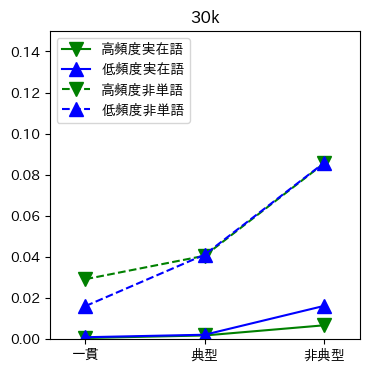

In [ ]:
K, ks = [], []
for i, k in enumerate(entropies):
    ks.append(k)
    if ((i+1) % 20) == 0:
        _ks = np.array(ks).mean()
        K.append(_ks)
        ks = []

K = np.array(K).reshape((4,3))

fig, ax = plt.subplots(1, figsize=(4, 4))

#ax[0].plot((20/20, 20/20, 17/20), marker="v", color="green", label="高頻度")
#ax[0].plot((20/20, 20/20, 14/20), marker="^", color="blue", label="低頻度")

ax.plot(K[0], marker="v", linestyle='-', color="green", markersize=10, label="高頻度実在語")
ax.plot(K[1], marker="^", linestyle='-', color="blue",  markersize=10, label="低頻度実在語")
ax.plot(K[2], marker="v", linestyle='--', color="green", markersize=10, label='高頻度非単語')
ax.plot(K[3], marker="^", linestyle='--', color="blue", markersize=10, label='低頻度非単語')
ax.set_xlim(-0.3,2.3)
ax.set_ylim(0,0.15)
ax.set_xticks(ticks=range(3))
ax.set_title('30k')
ax.legend(loc="upper left")
ax.set_xticklabels(labels=['一貫','典型','非典型'])
plt.savefig('2023_0304psylex71_20k_h256_fushimi1999_plot_entropies.pdf')

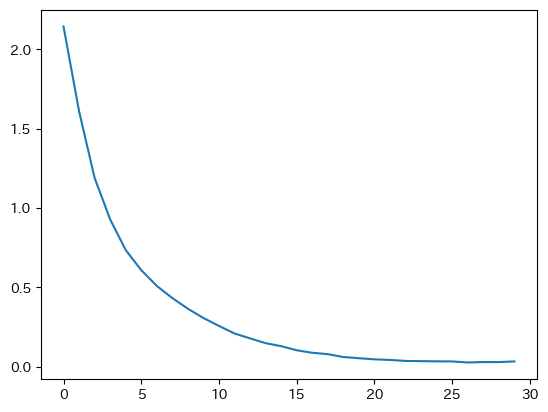

In [ ]:
import matplotlib.pyplot as plt
X = torch.load('RAM/2023_0214RAM_psylex71_10k_h256_nostoplist.pt')
plt.plot(X['losses'])

In [ ]:
cr_every = 4
entropies = []
for i, wrd in enumerate(fushimi1999_list[:]):
#for i, wrd in enumerate(fushimi1999_list[120:]):
    #print(i+121, wrd)
    dec_wrd, topvs = eval_input_seq2seq(encoder=encoder, decoder=decoder, ds=ds, inp_wrd=wrd, isPrint=False)
    dec_wrd = "".join(p for p in dec_wrd[:-1])
    # p = np.exp(np.array(topvs)).mean()
    # ent = - p * np.log(p)

    ent = np.array(topvs).mean()
    entropies.append(ent)
    _end = '\n' if ((i+1) % cr_every) == 0 else ", "
    print(f'{i+1:3d} {wrd}->/{dec_wrd}/ {ent:.4f}', end=_end)

  1 戦争->/seNso:/ -0.0000,   2 倉庫->/so:ko/ -0.0037,   3 医学->/igaku/ -0.0001,   4 注意->/chu:i/ -0.0004
  5 記念->/kineN/ -0.0000,   6 番号->/baNgo:/ -0.0002,   7 料理->/ryo:ri/ -0.0001,   8 完全->/kaNzeN/ -0.0001
  9 開始->/kaishi/ -0.0004,  10 印刷->/iNsatsu/ -0.0002,  11 連続->/reNzoku/ -0.0001,  12 予約->/yoyaku/ -0.0001
 13 多少->/tasho:/ -0.0005,  14 教員->/kyo:iN/ -0.0002,  15 当局->/to:kyoku/ -0.0001,  16 材料->/zairyo:/ -0.0000
 17 夕刊->/yu:kaN/ -0.0009,  18 労働->/ro:do:/ -0.0004,  19 運送->/uNso:/ -0.0005,  20 電池->/deNchi/ -0.0006
 21 反対->/haNtai/ -0.0001,  22 失敗->/shiqpai/ -0.0001,  23 作品->/sakuhiN/ -0.0001,  24 指定->/shitei/ -0.0003
 25 実験->/jiqkeN/ -0.0001,  26 決定->/keqtei/ -0.0000,  27 独占->/hitoriuranai/ -0.0200,  28 独身->/dokushiN/ -0.0020
 29 固定->/kotei/ -0.0002,  30 食品->/shokuhiN/ -0.0001,  31 表明->/hyo:mei/ -0.0002,  32 安定->/aNtei/ -0.0006
 33 各種->/kakushu/ -0.0007,  34 役所->/yakudokoro/ -0.0056,  35 海岸->/kaigaN/ -0.0006,  36 決算->/keqsaN/ -0.0000
 37 地帯->/chitai/ -0.0004,  38 道路->/do:ro/ -0.0007,  39 安打

In [ ]:
from RAM import eval_input_seq2seq
import numpy as np


# 3. `単語リスト（扱い注意).xls`

In [ ]:
import pandas as pd
fushimi1998_pd = pd.read_excel('単語リスト（扱い注意）.xlsx', sheet_name='伏見(1998)')
fushimi1998_wordlist = fushimi1998_pd['単語'].to_list()
#print(len(fushimi1998_wordlist))

sugiyama2019_pd = pd.read_excel('単語リスト（扱い注意）.xlsx', sheet_name='杉山（2019）')
sugiyama2019_wordlist = sugiyama2019_pd['刺激語'].to_list()
#print(sugiyama2019_wordlist)

for i, wrd in enumerate(sugiyama2019_wordlist+fushimi1998_wordlist):
    output = eval_input_seq2seq(encoder=encoder, decoder=decoder, ds=ds, inp_wrd=wrd, isPrint=False)
    print(f'{i+1:2d} {wrd}->{"".join(_p for _p in output[0][:-1])}/')
    #print(f'{i+1:2d} {wrd}:{output[0][:-1]}')

 1 道路->do:ro/
 2 料理->ryo:ri/
 3 食品->shokuhiN/
 4 戦争->seNso:/
 5 倉庫->so:ko/
 6 失敗->shiqpai/
 7 予約->yoyaku/
 8 実験->jiqkeN/
 9 教員->kyo:iN/
10 印刷->iNsatsu/
11 決着->keqchaku/
12 任務->niNmu/
13 安打->aNda/
14 表明->hyo:mei/
15 決算->keqsaN/
16 経由->keiyu/
17 指針->shishiN/
18 各種->kakushu/
19 地帯->chitai/
20 当局->to:kyoku/
21 台風->taifu:/
22 人形->niNgyo:/
23 人間->niNgeN/
24 彼女->kanojo/
25 夫婦->fu:fu/
26 建物->tatemono/
27 仲間->nakama/
28 夜間->yakaN/
29 相手->aite/
30 地元->jimoto/
31 東西->to:zai/
32 様子->yo:su/
33 日常->nichijo:/
34 南部->naNbu/
35 場合->ba:i/
36 内部->naibu/
37 下落->geraku/
38 日銀->nichigiN/
39 頭取->to:dori/
40 次第->shidai/
41 電池->deNchi/
42 夕刊->yu:kaN/
43 独身->dokushiN/
44 表紙->hyo:shi/
45 銀貨->giNka/
46 満開->maNkai/
47 食費->shokuhi/
48 祝福->shukufuku/
49 予告->yokoku/
50 和服->wafuku/
51 永続->eizoku/
52 越境->eqkyo:/
53 製材->seizai/
54 古代->kodai/
55 医局->ikyoku/
56 急送->kyu:so:/
57 信任->shiNniN/
58 曲折->kyokusetsu/
59 改選->kaiseN/
60 理学->rigaku/
61 豆腐->to:fu/
62 毛糸->keito/
63 献立->koNdate/
64 毛皮->kegawa/
65 競馬->keiba/
66 化粧->kesho

In [ ]:
fushimi1998_dict = {}
for k, v in fushimi1998_pd.iterrows():
    _wrd  = v['単語']
    _hira = v['ひらがな']
    _yomi = v['カタカナ']
    #_yomi = mecab_yomi(_wrd).strip()
    #_hira = jaconv.kata2hira(_yomi)
    _juli = jaconv.hiragana2julius(_hira).split()

    _output = eval_input_seq2seq(encoder=encoder, decoder=decoder, ds=ds, inp_wrd=_wrd, isPrint=False)
    fushimi1998_dict[_wrd] = {'ヨミ': _yomi,
                              'juli': _juli,
                              '出力': _output[0][:-1],
                              'yes/no': _juli == _output[0][:-1],
                              '親密度': v['Fam'],
                              '一貫性': v['Con'],
                              '心像性': v['Img']}

fams, consts, imags = {}, {}, {}                   # 単純集計
famXconst, famXimag, constXimag = {}, {}, {}  # クロス集計
famXconstXimag = {}                              # 3 次のクロス集計
for k, v in fushimi1998_dict.items():
    _fam, _const, _imag = v['親密度'], v['一貫性'], v['心像性']

    _fam_const  = _fam+':'+_const
    _fam_imag   = _fam+':'+_imag
    _const_imag = _const+':'+_imag
    _fam_const_imag = _fam+':'+_const+':'+_imag

    # 単純集計
    if not _fam in fams:
        fams[_fam] = []
    if not _const in consts:
        consts[_const] = []
    if not _imag in imags:
        imags[_imag] = []

    fams[_fam].append(v['yes/no'])
    consts[_const].append(v['yes/no'])
    imags[_imag].append(v['yes/no'])

    # クロス集計
    if not _fam_const in famXconst:
        famXconst[_fam_const] = []
    if not _fam_imag in famXimag:
        famXimag[_fam_imag] = []
    if not _const_imag in constXimag:
        constXimag[_const_imag] = []
    famXconst[_fam_const].append(v['yes/no'])
    famXimag[_fam_imag].append(v['yes/no'])
    constXimag[_const_imag].append(v['yes/no'])

    if not _fam_const_imag in famXconstXimag:
        famXconstXimag[_fam_const_imag] = []
    famXconstXimag[_fam_const_imag].append(v['yes/no'])


print('# 伏見1998 正解率')
print('## 単純集計')
print('### 親密度')
for k, v in fams.items():
    N = len(v)
    Hits = np.array(v *1).sum()
    print(f'{k}: {Hits/N*100:.1f}%')

print('### 一貫性')
for k, v in consts.items():
    N = len(v)
    Hits = np.array(v *1).sum()
    print(f'{k}: {Hits/N*100:.1f}%')

print('### 心像性')
for k, v in imags.items():
    N = len(v)
    Hits = np.array(v *1).sum()
    print(f'{k}: {Hits/N*100:.1f}%')

print('\n## クロス集計')
print('### 親密度 X 一貫性')
for k, v in sorted(famXconst.items()):
    N = len(v)
    Hits = np.array(v *1).sum()
    print(f'{k}: {Hits/N*100:.1f}%')

print('### 親密度 X 心像性')
for k, v in sorted(famXimag.items()):
    N = len(v)
    Hits = np.array(v *1).sum()
    print(f'{k}: {Hits/N*100:.1f}%')


print('### 一貫性 X 心像性')
for k, v in sorted(constXimag.items()):
    N = len(v)
    Hits = np.array(v *1).sum()
    print(f'{k}: {Hits/N*100:.1f}%')

print('\n## 3 重クロス集計')
for k, v in sorted(famXconstXimag.items()):
    N = len(v)
    Hits = np.array(v *1).sum()
    print(f'{k}: {Hits/N*100:.1f}%')
    #print(k, np.array(v * 1).sum(), len(v))


# 伏見1998 正解率
## 単純集計
### 親密度
H: 82.5%
L: 57.5%
### 一貫性
CON: 86.2%
ATP: 53.8%
### 心像性
H: 71.2%
L: 68.8%

## クロス集計
### 親密度 X 一貫性
H:ATP: 67.5%
H:CON: 97.5%
L:ATP: 40.0%
L:CON: 75.0%
### 親密度 X 心像性
H:H: 80.0%
H:L: 85.0%
L:H: 62.5%
L:L: 52.5%
### 一貫性 X 心像性
ATP:H: 57.5%
ATP:L: 50.0%
CON:H: 85.0%
CON:L: 87.5%

## 3 重クロス集計
H:ATP:H: 65.0%
H:ATP:L: 70.0%
H:CON:H: 95.0%
H:CON:L: 100.0%
L:ATP:H: 50.0%
L:ATP:L: 30.0%
L:CON:H: 75.0%
L:CON:L: 75.0%


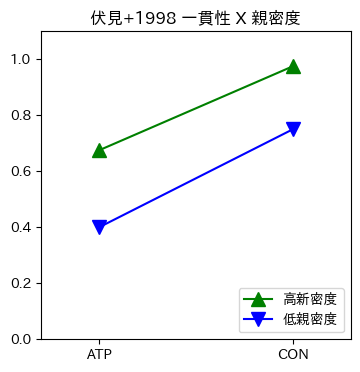

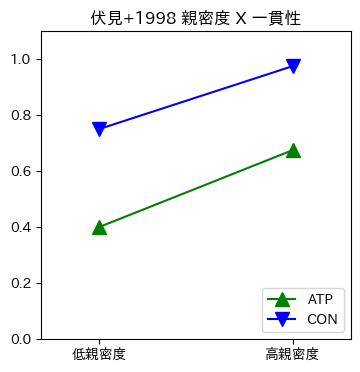

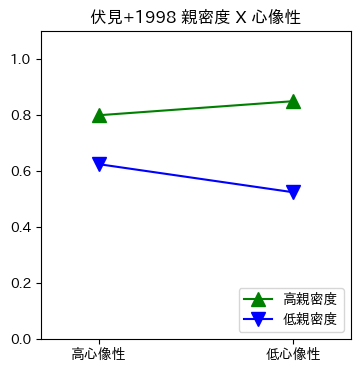

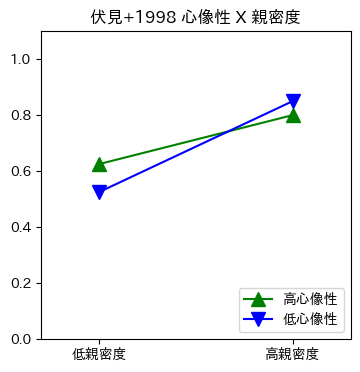

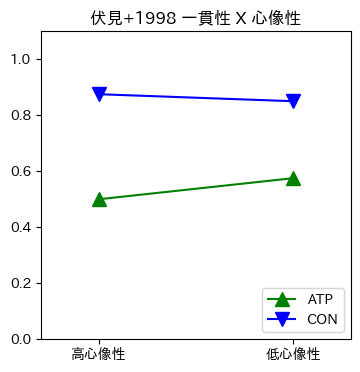

In [ ]:
#---
### 親密度 X 一貫性
plt.figure(figsize=(4,4))
plt.xlim(-0.3, 1.3)
plt.ylim(0,1.1)

plt.plot([0.675, 0.975], 'g^-', label='高新密度', markersize=10)
plt.plot([0.400, 0.750], 'bv-', label='低親密度', markersize=10)
plt.xticks([0, 1], [ "ATP", "CON"])
plt.legend(loc="lower right")
plt.title('伏見+1998 一貫性 X 親密度')
plt.show()

#---
### 親密度 X 心像性
plt.figure(figsize=(4,4))
plt.xlim(-0.3, 1.3)
plt.ylim(0,1.1)

plt.plot([0.400, 0.675], 'g^-', label='ATP', markersize=10)
plt.plot([0.750, 0.975], 'bv-', label='CON', markersize=10)
plt.xticks([0, 1], [ "低親密度", "高親密度"])
plt.legend(loc='lower right')
plt.title('伏見+1998 親密度 X 一貫性')
plt.show()

#---
### 親密度 X 心像性
# H:H: 80.0%
# H:L: 85.0%
# L:H: 62.5%
# L:L: 52.5%
plt.figure(figsize=(4,4))
plt.xlim(-0.3, 1.3)
plt.ylim(0,1.1)

plt.plot([0.800, 0.850], 'g^-', label='高親密度', markersize=10)
plt.plot([0.625, 0.525], 'bv-', label='低親密度', markersize=10)
plt.xticks([0, 1], [ "高心像性", "低心像性"])
plt.legend(loc='lower right')
plt.title('伏見+1998 親密度 X 心像性')
plt.show()

#---
### 親密度 X 心像性
# H:H: 80.0%
# H:L: 85.0%
# L:H: 62.5%
# L:L: 52.5%
plt.figure(figsize=(4,4))
plt.xlim(-0.3, 1.3)
plt.ylim(0,1.1)

plt.plot([0.625, 0.800], 'g^-', label='高心像性', markersize=10)
plt.plot([0.525, 0.850], 'bv-', label='低心像性', markersize=10)
plt.xticks([0, 1], [ "低親密度", "高親密度"])
plt.legend(loc='lower right')
plt.title('伏見+1998 心像性 X 親密度')
plt.show()

#--
### 一貫性 X 心像性
#ATP:H: 57.5%
#ATP:L: 50.0%
#CON:H: 85.0%
#CON:L: 87.5%
plt.figure(figsize=(4,4))
plt.xlim(-0.3, 1.3)
plt.ylim(0,1.1)

plt.plot([0.500, 0.575], 'g^-', label='ATP', markersize=10)
plt.plot([0.875, 0.850], 'bv-', label='CON', markersize=10)
plt.xticks([0, 1], [ "高心像性", "低心像性"])
plt.legend(loc='lower right')
plt.title('伏見+1998 一貫性 X 心像性')
plt.show()



```
## 3 重クロス集計
H:ATP:H: 65.0%
H:ATP:L: 70.0%
H:CON:H: 95.0%
H:CON:L: 100.0%
L:ATP:H: 50.0%
L:ATP:L: 30.0%
L:CON:H: 75.0%
L:CON:L: 75.0%

ちなみに 10K で近藤先生，伊集院先生にメールした数値は以下
## 3 重クロス集計
H:ATP:H: 65.0%
H:ATP:L: 65.0%
H:CON:H: 95.0%
H:CON:L: 100.0%
L:ATP:H: 50.0%
L:ATP:L: 35.0%
L:CON:H: 85.0%
L:CON:L: 75.0%

だから
#'HF_CON_HI': 0.950, 'HF_CON_LI':1.000,
#'HF_INC_HI': 0.650, 'HF_INC_LI':0.650,
#'LF_CON_HI': 0.850, 'LF_CON_LI':0.750,
#'LF_INC_HI': 0.500, 'LF_INC_LI':0.350,
Z = np.array([0.950, 1.000, 0.650, 0.650, 0.850, 0.750, 500, 350])

```
<img src="1998伏見_fig.svg">

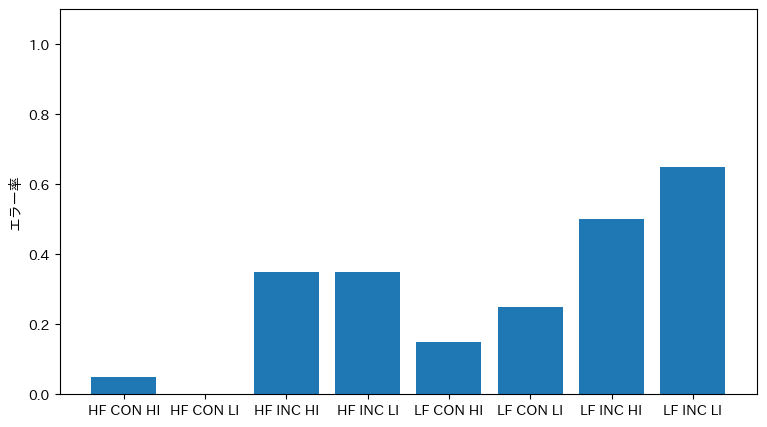

In [ ]:
#'HF_CON_HI': 0.950, 'HF_CON_LI':1.000,
#'HF_INC_HI': 0.650, 'HF_INC_LI':0.700,
#'LF_CON_HI': 0.750, 'LF_CON_LI':0.750,
#'LF_INC_HI': 0.500, 'LF_INC_LI':0.300,
Z =np.array([ 0.950, 1.000, 0.650, 0.700,  0.750, 0.750, 0.500, 0.300])
Z2 = np.array([0.950, 1.000, 0.650, 0.650, 0.850, 0.750, 0.500, 0.350])
Z_ = 1 - Z2
Z_
plt.figure(figsize=(9,5))
plt.ylim(0,1.1)
plt.ylabel('エラー率')
plt.xticks([0, 1, 2,3,4,5,6,7], ["HF CON HI", "HF CON LI", "HF INC HI", "HF INC LI", "LF CON HI", "LF CON LI", "LF INC HI", "LF INC LI"])
plt.bar([0,1,2,3,4,5,6,7],Z_)
plt.savefig('2023_0410ram_fushimi1998_o2p_10k.pdf')

# 4. '1000stimulus-proponly-New2_2022.xls'

In [ ]:
if isColab:
    from google.colab import files
    uploaded = files.upload()


In [ ]:
kondo_pd = pd.read_excel('1000stimulus-proponly-New2_2022.xls', sheet_name='data')
kondo1000_dict = {}
for r in kondo_pd.iterrows():
    #print(type(r),r[0], type(r[1]), len(r[1]), r[1].to_dict().keys())
    idx = r[1]['id']
    wrd = r[1]['kanji1']+r[1]['kanji2']
    phon = [r[1]['mora11'], r[1]['mora12'], r[1]['mora21'], r[1]['mora22']]
    kondo1000_dict[idx] = {'wrd':wrd, 'phon':phon, 'dict':r[1]}

n_hit = 0
for i, (idx, v) in enumerate(kondo1000_dict.items()):
    wrd = v['wrd']
    phn = v['phon']
    output = eval_input_seq2seq(encoder=encoder, decoder=decoder, ds=ds, inp_wrd=wrd, isPrint=False)
    res = "".join(_p for _p in output[0][:-1])
    tch = "".join(_p for _p in phn)
    yesno = res == tch
    color = 'grey' if yesno else 'red'
    if yesno:
        n_hit += 1
    if not yesno:
        print(f'{i:04d} {wrd}->', f'/{res}/',  f'/{tch}/', colored(yesno,color,attrs=['bold']))

    if i > 10:
        break
print(f'n_hit:{n_hit}')


0000 合鍵-> /gatsuki/ /aikagi/ False
0001 相方-> /aiko:/ /aikata/ False
0002 合鴨-> /go:shi/ /aigamo/ False
0004 相槌-> /aisho:/ /aizuchi/ False
0006 青筋-> /seisuji/ /aosuji/ False
0007 青竹-> /sonika/ /aodake/ False
0008 青豆-> /seime/ /aomame/ False
0009 赤紙-> /sekishi/ /akagami/ False
0010 赤錆-> /akasuki/ /akasabi/ False
0011 赤潮-> /akaho/ /akashio/ False
n_hit:2


In [ ]:
kondo_pd = pd.read_excel('1000stimulus-proponly-New2_2022.xls', sheet_name='data')
#kondo1000_dict = {}

n_hit = 0
reses = []
yesnos = []
for r in kondo_pd.iterrows():
    idx = r[1]['id']
    wrd = r[1]['kanji1']+r[1]['kanji2']
    phon = [r[1]['mora11'], r[1]['mora12'], r[1]['mora21'], r[1]['mora22']]
    #kondo1000_dict[idx] = {'wrd':wrd, 'phon':phon, 'dict':r[1]}
    output = eval_input_seq2seq(encoder=encoder, decoder=decoder, ds=ds, inp_wrd=wrd, isPrint=False)
    res = "".join(_p for _p in output[0][:-1])
    tch = "".join(_p for _p in phon)
    yesno = res == tch
    color = 'grey' if yesno else 'red'
    if yesno:
        n_hit += 1

    i = len(reses)
    #if yesno:
    print(f'{i:04d} {wrd}->', f'/{res}/',  f'/{tch}/', colored(yesno,color,attrs=['bold']))

    reses.append(res)
    yesnos.append(yesno)
    if len(reses) > 20:
        break

#kondo_pd['model_output'] = reses
#kondo_pd['yes/no'] = yesnos
print(f'n_hit:{n_hit}')

0000 合鍵-> /gatsuki/ /aikagi/ False
0001 相方-> /aiko:/ /aikata/ False
0002 合鴨-> /go:shi/ /aigamo/ False
0003 愛犬-> /aikeN/ /aikeN/ True
0004 相槌-> /aisho:/ /aizuchi/ False
0005 青色-> /aoiro/ /aoiro/ True
0006 青筋-> /seisuji/ /aosuji/ False
0007 青竹-> /sonika/ /aodake/ False
0008 青豆-> /seime/ /aomame/ False
0009 赤紙-> /sekishi/ /akagami/ False
0010 赤錆-> /akasuki/ /akasabi/ False
0011 赤潮-> /akaho/ /akashio/ False
0012 赤札-> /akasatsu/ /akafuda/ False
0013 秋草-> /akiso:/ /akikusa/ False
0014 悪筆-> /akuhitsu/ /akuhitsu/ True
0015 朝方-> /asagata/ /asagata/ True
0016 朝露-> /asari/ /asatsuyu/ False
0017 足型-> /ashikawa/ /ashigata/ False
0018 足軽-> /sho:keki/ /ashigaru/ False
0019 足並-> /ashinami/ /ashinami/ True
0020 足早-> /ashibaya/ /ashibaya/ True
n_hit:6


In [ ]:
kondo_pd.to_excel('2023_0410_1000stimulus-proponly-New2_2022.xlsx')

In [ ]:
kondo_pd = pd.read_excel('1000stimulus-proponly-New2_2022.xls', sheet_name='data')
kondo_word1list = kondo_pd['kanji1'].to_list()
kondo_word2list = kondo_pd['kanji2'].to_list()
kondo_ids = kondo_pd['id'].to_list()
kondo1000_dict = {}
for i, (idx, _1, _2) in enumerate(zip(kondo_ids, kondo_word1list, kondo_word2list)):
    wrd = _1+_2
    output = eval_input_seq2seq(encoder=encoder, decoder=decoder, ds=ds, inp_wrd=wrd, isPrint=False)
    if (i % 200) == 0:
        print(f'{i:04d} {wrd}->/{"".join(_p for _p in output[0][:-1])}/')
    #print(_1+_2)

In [ ]:
kondo1000_ldt_df = pd.read_excel('../1000ldt-dataonly_2022.xls')
kondo1000_ldt_dict = {}
for i, r in enumerate(kondo1000_ldt_df.iterrows()):
    idx = r[1]['id']
    wrd = kondo1000_dict[idx]['wrd']

    if not idx in kondo1000_ldt_dict:
        kondo1000_ldt_dict[idx] = []
    if isinstance(r[1]['ldtRT'], int):
        kondo1000_ldt_dict[idx].append(r[1]['ldtRT'])
    if (i % 100000) == 0:
        print(f'{idx: 6d} {wrd}',
              r[1]['ldtRT'],
              type(r[1]['ldtRT']),
              r[1]['res'])

for k, v in kondo1000_ldt_dict.items():
    idx = k
    wrd = kondo1000_dict[idx]['wrd']
    kondo1000_ldt[idx]['N'] = len(v)
    kondo1000_ldt[idx]['mena'] = np.mean(v)
    kondo1000_ldt[idx]['sd'] = np.std(v)
    print(f'{wrd}',
          f'{len(v):02d}',
          f'{np.mean(v):.2f}',
          f'{np.std(v):.2f}')